# RNN from Library

In [1]:
from keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import set_random_seed
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import f1_score
from typing import Callable
%matplotlib inline

In [2]:
# From https://keras.io/examples/keras_recipes/reproducibility_recipes
# To make this whole notebook reproducible, no need to export the weights to a file except the best one

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(1)

## Load Data

In [3]:
# Database already separated, so kind
train_df = pd.read_csv("../../dataset/rnn/train.csv")
test_df = pd.read_csv("../../dataset/rnn/test.csv")

In [4]:
train_df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


## Cleaning Data

In [5]:
label_mapping = {"negative": 0,
                 "neutral": 1,
                 "positive": 2
                 }

# Take text and label only
train_df = train_df[["text", "label"]]
test_df = test_df[["text", "label"]]

# Warning!!! Not idempotent operations :(
train_df["label"] = train_df["label"].map(label_mapping)
test_df["label"] = test_df["label"].map(label_mapping)

In [6]:
# Sanity check, the label should be mapped to 0, 1, or 2
train_df

,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,1
1,Kue-kue yang disajikan bikin saya bernostalgia...,2
2,Ibu pernah bekerja di grab indonesia,1
3,Paling suka banget makan siang di sini ayam sa...,2
4,Pelayanan bus DAMRI sangat baik,2
...,...,...
495,Si A omongnya tong kosong nyaring bunyinya bic...,0
496,Sambalnya tidak akan ada di tempat lain. Rasa ...,2
497,"Menurut saya steaknya cukup enak, hanya lebih ...",2
498,Dijaga ya makannya gus emang lagi musimnya sek...,0


## Separate Text and Label

In [7]:
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

## Tokenizer

In [8]:
vectorizer = TextVectorization(
    output_mode='int'
)
vectorizer.adapt(train_texts)

## Split Train and Test Data

In [9]:
x_train = vectorizer(np.array(train_texts))
x_test = vectorizer(np.array(test_texts))

y_train = np.array(train_labels)
y_test = np.array(test_labels)

## Model

In [10]:
embedding_dim = 100
max_tokens = len(vectorizer.get_vocabulary())

# Automate the model creation, because why not?
def create_rnn_model(n_layers=1, rnn_units=64, isBidirectional=False):
    model = Sequential()
    model.add(Embedding(input_dim=max_tokens, output_dim=embedding_dim))

    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        if isBidirectional:
            model.add(Bidirectional(SimpleRNN(rnn_units, return_sequences=return_seq)))
        else:
            model.add(SimpleRNN(rnn_units, return_sequences=return_seq))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

## Validation

### Layer Variation

In [11]:
histories_layers = {}
for layers in [1, 2, 3]:
    model_tmp = create_rnn_model(n_layers=layers, rnn_units=64, isBidirectional=True)
    history = model_tmp.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)
    histories_layers[layers] = history

    preds = model_tmp.predict(x_test)
    preds_labels = np.argmax(preds, axis=1)
    f1 = f1_score(y_test, preds_labels, average='macro')
    print(f"Macro F1-score with {layers} layer(s) of RNN: {f1:.4f}")


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3547 - loss: 1.1156 - val_accuracy: 0.5600 - val_loss: 0.9950
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6164 - loss: 0.8877 - val_accuracy: 0.5400 - val_loss: 0.9760
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8543 - loss: 0.6616 - val_accuracy: 0.5300 - val_loss: 0.9856
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9072 - loss: 0.4072 - val_accuracy: 0.4900 - val_loss: 1.0153
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9848 - loss: 0.2076 - val_accuracy: 0.4600 - val_loss: 1.1038
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Macro F1-score with 1 layer(s) of RNN: 0.4567
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3848 - loss: 1.1767 - val_accuracy: 0.4000 - val_loss: 1.0479
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7251 - loss: 0.7202 - val_accuracy: 0.4400 - val_loss: 1.0426
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━

Text(0, 0.5, 'Loss')

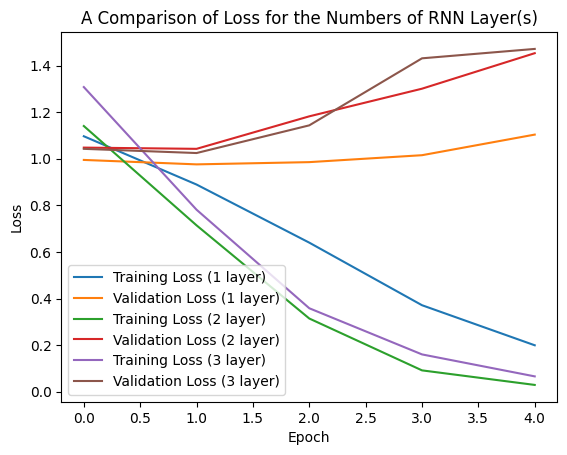

In [12]:
for layers, history in histories_layers.items():
    plt.plot(history.history['loss'], label=f'Training Loss ({layers} layer)')
    plt.plot(history.history['val_loss'], label=f'Validation Loss ({layers} layer)')
plt.legend()
plt.title("A Comparison of Loss for the Numbers of RNN Layer(s)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### RNN Unit (Cell) Variation

In [13]:
histories_units = {}
for units in [32, 64, 128]:
    model_tmp = create_rnn_model(n_layers=2, rnn_units=units, isBidirectional=True)
    history = model_tmp.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)
    histories_units[units] = history
    preds = model_tmp.predict(x_test)
    preds_labels = np.argmax(preds, axis=1)
    f1 = f1_score(y_test, preds_labels, average='macro')
    print(f"Macro F1-score with {units} unit(s): {f1:.4f}")

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.3201 - loss: 1.2074 - val_accuracy: 0.5000 - val_loss: 0.9837
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7418 - loss: 0.7530 - val_accuracy: 0.5100 - val_loss: 0.9463
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9036 - loss: 0.4934 - val_accuracy: 0.5000 - val_loss: 1.0023
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9744 - loss: 0.2806 - val_accuracy: 0.5000 - val_loss: 1.0521
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9908 - loss: 0.1409 - val_accuracy: 0.5700 - val_loss: 1.0692
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Macro F1-score with 32 unit(s): 0.5121
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.3784 - loss: 1.1485 - val_accuracy: 0.4300 - val_loss: 1.0076
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6540 - loss: 0.8388 - val_accuracy: 0.4700 - val_loss: 0.9336
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

Text(0, 0.5, 'Loss')

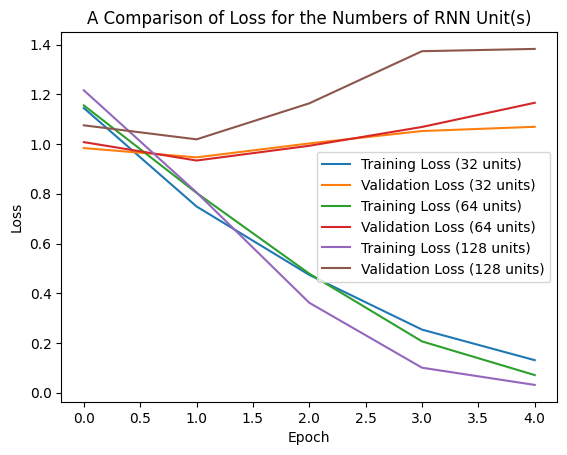

In [14]:
for layers, history in histories_units.items():
    plt.plot(history.history['loss'], label=f'Training Loss ({layers} units)')
    plt.plot(history.history['val_loss'], label=f'Validation Loss ({layers} units)')
plt.legend()
plt.title("A Comparison of Loss for the Numbers of RNN Unit(s)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Direction Variation

In [15]:
models_direction = {}
for direction in [False, True]:
    type = "Unidirectional" if not direction else "Bidirectional"
    model_tmp = create_rnn_model(n_layers=2, rnn_units=64, isBidirectional=direction)
    history = model_tmp.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)
    models_direction[type] = (model_tmp, history)
    preds = model_tmp.predict(x_test)
    preds_labels = np.argmax(preds, axis=1)
    f1 = f1_score(y_test, preds_labels, average='macro')
    print(f"Macro F1-score with {type} RNN: {f1:.4f}")

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3061 - loss: 1.2223 - val_accuracy: 0.3800 - val_loss: 1.0839
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4644 - loss: 1.0310 - val_accuracy: 0.2600 - val_loss: 1.2411
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7035 - loss: 0.7183 - val_accuracy: 0.3600 - val_loss: 1.1998
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9112 - loss: 0.3583 - val_accuracy: 0.3100 - val_loss: 1.7011
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9689 - loss: 0.1678 - val_accuracy: 0.3400 - val_loss: 1.7028
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Macro F1-score with Unidirectional RNN: 0.3468
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.4010 - loss: 1.1707 - val_accuracy: 0.4900 - val_loss: 0.9921
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6396 - loss: 0.8271 - val_accuracy: 0.5000 - val_loss: 0.9926
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━

Text(0, 0.5, 'Loss')

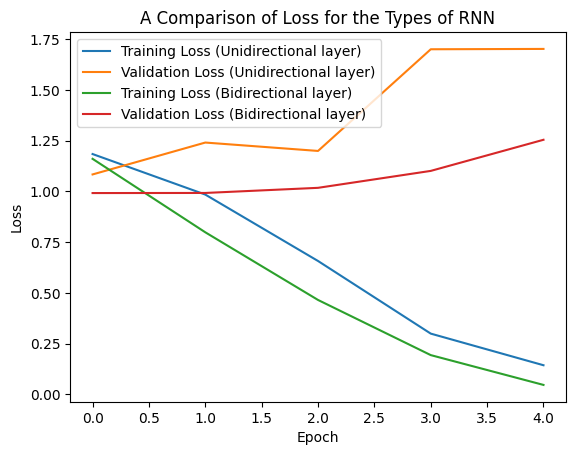

In [16]:
for type, (_, history) in models_direction.items():
    plt.plot(history.history['loss'], label=f'Training Loss ({type} layer)')
    plt.plot(history.history['val_loss'], label=f'Validation Loss ({type} layer)')
plt.legend()
plt.title("A Comparison of Loss for the Types of RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Export the Hidden Weights

In [17]:
# Pick the best model produces in testing which is 32 units of RNN with loss = 0.5121
best_model: Sequential = histories_units[32].model
preds = best_model.predict(x_test)
preds_labels = np.argmax(preds, axis=1)
f1 = f1_score(y_test, preds_labels, average='macro')
print(f"F1-Score (to verify) = {f1:.4f}")

# After verifying it, export to a file
best_model.save_weights("./training_result/SimpleRNN.weights.h5")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
F1-Score (to verify) = 0.5121


# RNN from Scratch

## Extract weight from Library

### RNN From Library

In [18]:
# Why remake a different model? To make return_seq = False
model = Sequential([
    Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=100),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)

keras_weights = model.get_layer(index=1).get_weights()

input_weight = keras_weights[0].T
hidden_weight = keras_weights[1]
bias_weight = keras_weights[2]

embedding_layer = model.get_layer(index=0)
x_test_embedded = embedding_layer(x_test).numpy()

class RNNScratch:
    def __init__(self,
                 input_weight: NDArray[np.float64],
                 hidden_weight: NDArray[np.float64],
                 hidden_bias_weight: NDArray[np.float64],
                 activation: Callable[[NDArray[np.float64]], NDArray[np.float64]] = np.tanh) -> None:
        self.input_weight = input_weight
        self.hidden_weight = hidden_weight
        self.bias_weight = hidden_bias_weight
        self.activation = activation

    def forward(self,
                input_feature: NDArray[np.float64],
                h_state_prev: NDArray[np.float64] | None = None) -> NDArray[np.float64]:
        """
        ### h_t = f(U . x_t + W . h_t-1 + b_xh)

        Legend:
        U : Input weight matrix
        W : Hidden weight matrix
        x_t : Feature vector (i features) at step t
        h_t : Hidden state
        f: activation function
        """
        batch_size, seq_length, _ = input_feature.shape
        hidden_dim = self.bias_weight.shape[0]

        if h_state_prev is None:
            h_state_prev = np.zeros((batch_size, hidden_dim))

        for t in range(seq_length):
            x_t = input_feature[:, t, :]

            # h_t = tanh( x_t . input_weight.T + h_state_prev . hidden_weight.T + bias )
            h_t = self.activation(
                np.matmul(x_t, self.input_weight.T) +
                np.matmul(h_state_prev, self.hidden_weight.T) + # type: ignore
                self.bias_weight
            )

            h_state_prev = h_t

        return h_state_prev # type: ignore

rnn_scratch = RNNScratch(
    input_weight=input_weight,
    hidden_weight=hidden_weight,
    hidden_bias_weight=bias_weight
)

scratch_rnn_output = rnn_scratch.forward(input_feature=x_test_embedded)

rnn_model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, weights=embedding_layer.get_weights(), trainable=False),
    model.get_layer(index=1)
])

keras_rnn_output = rnn_model(x_test).numpy()

print("RNNScratch forward output (shape):", scratch_rnn_output.shape)
print("Keras RNN output (shape):", keras_rnn_output.shape)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3675 - loss: 1.1056 - val_accuracy: 0.3500 - val_loss: 1.1009
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4615 - loss: 1.0480 - val_accuracy: 0.4000 - val_loss: 1.1058
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7018 - loss: 0.8206 - val_accuracy: 0.3700 - val_loss: 1.1566
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8620 - loss: 0.5722 - val_accuracy: 0.3000 - val_loss: 1.2537
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9586 - loss: 0.4233 - val_accuracy: 0.3200 - val_loss: 1.3206
RNNScratch forward output (shape): (400, 32)
Keras RNN output (shape): (400, 32)


In [19]:
# Lib
lib_pred = rnn_model.predict(x_test)
lib_pred_label = np.argmax(lib_pred, axis=1)
lib_f1 = f1_score(y_test, lib_pred_label, average='macro')

# Scratch (Manual predict...)
dense_layer = model.get_layer(index=3)
dense_weights = dense_layer.get_weights()
W_dense = dense_weights[0]
b_dense = dense_weights[1]
out = np.dot(scratch_rnn_output, W_dense) + b_dense
scratch_pred = softmax(out)
scratch_pred_label = np.argmax(scratch_pred, axis=1)
scratch_f1 = f1_score(y_test, scratch_pred_label, average='macro')

# Print res
print(f"Keras' F1-Score = {lib_f1:.4f}")
print("RNNScratch F1-score:", scratch_f1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Keras' F1-Score = 0.0037
RNNScratch F1-score: 0.33593396807222486


In [20]:
lib_pred[:3]

array([[-0.46191344, -0.10041235, -0.26632804,  0.00828841,  0.4921354 ,
        -0.5077523 , -0.40412125, -0.68003976, -0.12833524,  0.14900939,
        -0.06263445, -0.11354244, -0.24431953, -0.29919654,  0.2510089 ,
         0.46533746, -0.2232139 , -0.23718308,  0.0260891 , -0.3024738 ,
        -0.258453  , -0.34173834,  0.02369095, -0.33592016,  0.18111639,
         0.35413188, -0.38282952,  0.5465683 , -0.26704553,  0.11913288,
         0.18160775,  0.33023924],
       [-0.25654212,  0.24607275,  0.3218513 ,  0.28175282,  0.2580398 ,
        -0.3834132 ,  0.01066528, -0.41292155,  0.12157219,  0.36698034,
         0.23158321, -0.37465268, -0.03177598, -0.06132335,  0.03383045,
         0.43753412,  0.13350251,  0.05189261, -0.30292538, -0.13595396,
        -0.43513218, -0.677843  , -0.3974343 , -0.50262755,  0.4856558 ,
         0.27999777, -0.05898659,  0.47997916, -0.24882461,  0.3101104 ,
         0.0444005 ,  0.10490727],
       [-0.37394813, -0.25084054, -0.26253852,  0.1576

In [21]:
scratch_pred[:3]

array([[0.00180124, 0.00032877, 0.00041363],
       [0.00030307, 0.00183194, 0.00084585],
       [0.00143397, 0.00049295, 0.00035474]])